In [1]:
# essas duas linhas e para te permitir atualizar codigo no vscode automaticamente e usar aqui no jupyter sem ter que
# reimportar
%load_ext autoreload
%autoreload 2

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

# Custom imports
from models import lstm_model

In [20]:
# carregando dados de treino
df_x = pd.read_csv("./dataset/Training/TrainingAccZAxis.txt", header=None)
df_x.columns =[ "AccZAxis"]
df_y = pd.read_csv("./dataset/Training/TrainingStepsOrNot.txt", header=None)
df_y.columns =[ "Step"]

# carregando dados de teste
df_x_test = pd.read_csv("./dataset/Testing/TestingAccZAxis.txt", header=None)
df_x_test.columns =[ "AccZAxis"]
df_y_test = pd.read_csv("./dataset/Testing/TestingStepsOrNot.txt", header=None)
df_y_test.columns =[ "Step"]

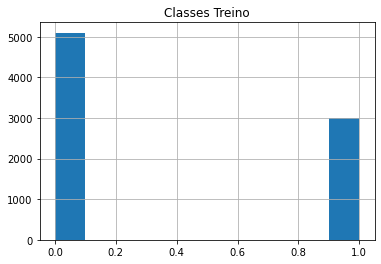

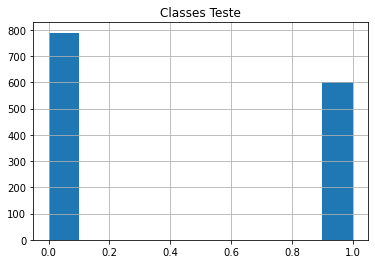

In [21]:
# visualizando uma distribuicao de classes nos dados de treino e teste
df_y.hist()
plt.title("Classes Treino")
plt.show()
df_y_test.hist()
plt.title("Classes Teste")
plt.show()

In [39]:
# preprocessing basico dos dados (acertando a shape para fazer fit nos modelos)
X_train, y_train = df_x.values.ravel(), df_y.values.ravel()
X_train = X_train.reshape(-1,1,1)
# scale training data to [-1,1]
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())

X_test, y_test = df_x_test.values.ravel(), df_y_test.values.ravel()
X_test = X_test.reshape(-1,1,1)
# scale testing data to [-1,1]
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [40]:
X_train.shape

(8100, 1, 1)

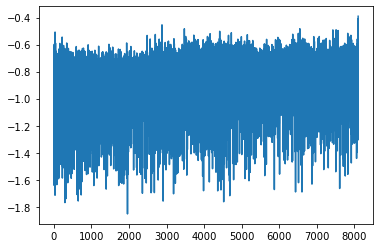

In [32]:
plt.plot(X_train[:,0,0])
plt.show()

In [43]:
# inicializando os modelos
lr = LogisticRegression()
rf = RandomForestClassifier()
lstm = lstm_model(n_timesteps=1, n_features=1, n_outputs=1)

# fazendo fit do modelo random forest
# referencia para entender random forest classifiers: https://towardsdatascience.com/understanding-random-forest-58381e0602d2
# rf.fit(X_train, y_train)
# lr.fit(X_train,y_train)
epochs = 20
batch_size = 64
lstm.fit(X_train, y_train, epochs=epochs,batch_size=batch_size, verbose=1)

Epoch 1/20
127/127 [==============================] - 1s 2ms/step - loss: 0.6573 - accuracy: 0.6295
Epoch 2/20
127/127 [==============================] - 0s 2ms/step - loss: 0.5796 - accuracy: 0.6771
Epoch 3/20
127/127 [==============================] - 0s 2ms/step - loss: 0.4681 - accuracy: 0.8051
Epoch 4/20
127/127 [==============================] - 0s 2ms/step - loss: 0.4113 - accuracy: 0.8305
Epoch 5/20
127/127 [==============================] - 0s 2ms/step - loss: 0.3941 - accuracy: 0.8418
Epoch 6/20
127/127 [==============================] - 0s 2ms/step - loss: 0.4031 - accuracy: 0.8277
Epoch 7/20
127/127 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8381
Epoch 8/20
127/127 [==============================] - 0s 2ms/step - loss: 0.3916 - accuracy: 0.8324
Epoch 9/20
127/127 [==============================] - 0s 2ms/step - loss: 0.3889 - accuracy: 0.8403
Epoch 10/20
127/127 [==============================] - 0s 2ms/step - loss: 0.3969 - accuracy: 0.8359

In [53]:
# source: https://keras.io/examples/timeseries/timeseries_transformer_classification/
from keras import layers
from models import *

n_classes = 1
epochs = 500

input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
    n_classes=n_classes,
)

model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, y_test, verbose=1)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1, 1)]       0                                            
__________________________________________________________________________________________________
layer_normalization_40 (LayerNo (None, 1, 1)         2           input_8[0][0]                    
__________________________________________________________________________________________________
multi_head_attention_20 (MultiH (None, 1, 1)         7169        layer_normalization_40[0][0]     
                                                                 layer_normalization_40[0][0]     
__________________________________________________________________________________________________
dropout_57 (Dropout)            (None, 1, 1)         0           multi_head_attention_20[0][

[0.7338070869445801, 0.49028077721595764]

In [64]:
# obtendo as predictions nos dados de teste
predictions_rf = rf.predict(X_test)
predictions_lr = lr.predict(X_test)

In [65]:
# obtendo a performance dos modelos

accuracy_score_rf = accuracy_score(y_test, predictions_rf)
accuracy_score_lr = accuracy_score(y_test, predictions_lr)

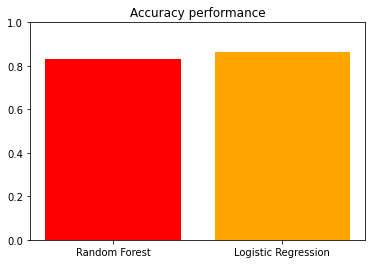

In [67]:
# visualizando as performances
import matplotlib.pyplot as plt
plt.bar(["Random Forest","Logistic Regression"],height=[accuracy_score_rf,accuracy_score_lr], color=["red","orange"])
plt.title("Accuracy performance")
plt.ylim(0,1)
plt.show()